In [1]:
import numpy as np
import json
from munch import Munch
import itertools
from collections import defaultdict
import random
import copy
import torch
import importlib
import time

import apt_helper as ahlp
import apt_cst_aggregate as cagg

import apt_EM as em

import matplotlib.pyplot as plt

In [2]:
names = ['apt','bob','sally']
mu_list = [.8,.9,.9]
apt_hmm, bob_hmm, sally_hmm = ahlp.process_load(names, delay = mu_list)
user_list = [bob_hmm, sally_hmm]

In [3]:
#Check if correctly loaded. probabilities should sum to 1.
for usr in user_list:
    usr_params = ahlp.hmm2numpy(usr)
    print(f'initprob:{usr_params[0].sum()}  tprob: {usr_params[1].sum(axis = 1)}  eprob: {usr_params[2].sum(axis = 1)}')

initprob:1.0  tprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]  eprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
initprob:1.0  tprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]  eprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
apt_params = ahlp.hmm2numpy(apt_hmm)
print(f'initprob:{apt_params[0].sum()}  tprob: {apt_params[1].sum(axis = 1)}  eprob: {apt_params[2].sum(axis = 1)}')

initprob:1.0  tprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]  eprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [5]:
cst_names = ['know_sally_exists','have_sally_credential', 'learn_where_data_stored', 'have_data_on_ds', 'have_data_on_hi', 'have_data_on_he']
cst_names = [names + '_TRUE' for names in cst_names]
cst_list=  []
for name in cst_names:
    module = importlib.import_module(name)
    
    curr_cst =  Munch(name = module.name, \
                      aux_size = module.aug_size, \
                      update_fun = module.update_fun, \
                      init_fun = module.init_fun, \
                      forbidden_emissions = module.forbidden_emissions, \
                      forbidden_transitions = module.forbidden_transitions, \
                      knowledge_state = module.knowledge_state, \
                      cst_fun = module.cst_fun)
    if hasattr(module, 'dependency'):
        curr_cst.dependency = module.dependency
    cst_list.append(curr_cst)

sat = len(cst_list) * (True,)

In [6]:
importlib.reload(em)

<module 'apt_EM' from '/home/fyqiu/Projects/conin/conin/mediation_variables/apt_EM.py'>

In [7]:
ordered_apt, wait_list = em.apt_preprocess(apt_hmm, device = 'cuda:0')

In [8]:
true_hmm_params, cst_params = em.em_convertTensor(ordered_apt, cst_list, rand_init = False, dtype = torch.float32, device = 'cuda:0', return_ix = False)

In [9]:
B = 200
seq_list = []
for b in range(B):
    apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
    seq_list.append(combined_emits)

weight_list = em.em_emitweights(apt_hmm,seq_list, mix_param = .81)

In [61]:
new_apt, new_params, time_list = em.apt_EM_v2(apt_hmm, cst_list, seq_list,  device ='cuda:0', conv = 1e-4, max_step = 100, \
                                        dtype = torch.float32, rand_init = True, mix_param = .81, timer = True, fix_mu = None)

Step:0, neg log prob: 50365.29131317139, log_prob_change %: 0.006139475025495952
Step:1, neg log prob: 50283.48149108887, log_prob_change %: 0.001624329373453358
Step:2, neg log prob: 50218.09591674805, log_prob_change %: 0.0013003390457840078
Step:3, neg log prob: 50166.48570251465, log_prob_change %: 0.0010277214476422654
Step:4, neg log prob: 50130.59785461426, log_prob_change %: 0.0007153749639391564
Step:5, neg log prob: 50107.82002258301, log_prob_change %: 0.00045436984608300296
Step:6, neg log prob: 50092.147468566895, log_prob_change %: 0.00031277660870199193
Step:7, neg log prob: 50078.16529083252, log_prob_change %: 0.0002791291338257937
Step:8, neg log prob: 50063.038749694824, log_prob_change %: 0.0003020586127675973
Step:9, neg log prob: 50045.18259429932, log_prob_change %: 0.0003566734229774788
Step:10, neg log prob: 50024.00099182129, log_prob_change %: 0.0004232495792799876
Step:11, neg log prob: 49999.930000305176, log_prob_change %: 0.00048118885012913675
Step:12, n

In [62]:
sum(time_list)/len(time_list)

31.41660919836012

In [63]:
new_params[3]

0.8844900524161395

In [64]:
_, _, true_log_prob, debug_prob_list, message_list = em.apt_BW(weight_list, true_hmm_params,cst_params, debug = True)
og_gamma, og_xi = message_list
print(f'original log prob {-1*-1*true_log_prob}')
# print(og_gamma.sum(dim=(1,2)))
# print(og_xi)

original log prob -51708.73718261719


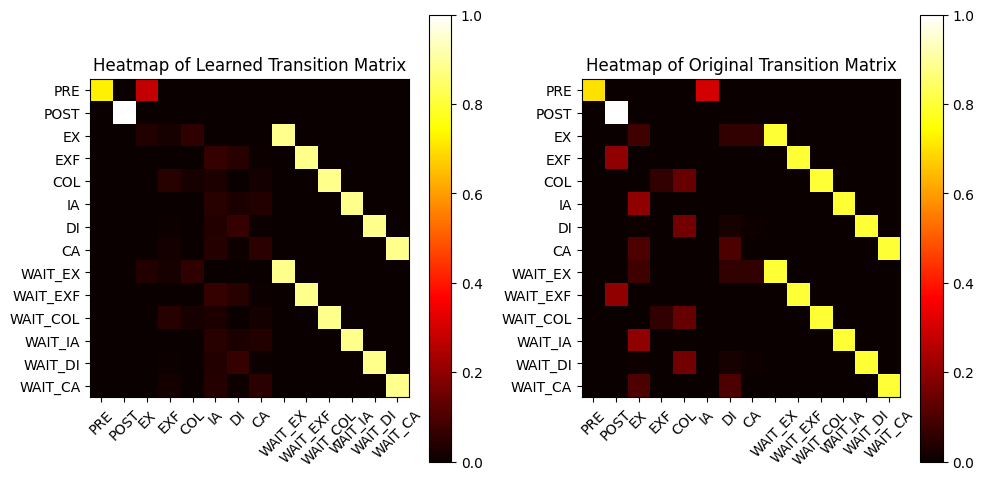

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first heatmap
# cax1 = axes[0].imshow(new_params[0][:(2+L),:(2+L)].cpu(), cmap='hot', interpolation='nearest')
cax1 = axes[0].imshow(new_params[0].cpu(), cmap='hot', interpolation='nearest')
axes[0].set_title('Heatmap of Learned Transition Matrix')
axes[0].set_xticks(np.arange(len(list(ordered_apt.states))))
axes[0].set_xticklabels(list(ordered_apt.states), rotation=45)
axes[0].set_yticks(np.arange(len(list(ordered_apt.states))))
axes[0].set_yticklabels(list(ordered_apt.states))

fig.colorbar(cax1, ax=axes[0])

# Plot the second heatmap
# cax2 = axes[1].imshow(hmm_params[0][:(2+L),:(2+L)].cpu(), cmap='hot', interpolation='nearest')
cax2 = axes[1].imshow(true_hmm_params[0].cpu(), cmap='hot', interpolation='nearest')
axes[1].set_title('Heatmap of Original Transition Matrix')
axes[1].set_xticks(np.arange(len(list(ordered_apt.states))))
axes[1].set_xticklabels(list(ordered_apt.states), rotation=45)
axes[1].set_yticks(np.arange(len(list(ordered_apt.states))))
axes[1].set_yticklabels(list(ordered_apt.states))

fig.colorbar(cax2, ax=axes[1])

# Show the plots
plt.tight_layout()
plt.show()


In [66]:
new_apt.states

['PRE',
 'POST',
 'EX',
 'EXF',
 'COL',
 'IA',
 'DI',
 'CA',
 'WAIT_EX',
 'WAIT_EXF',
 'WAIT_COL',
 'WAIT_IA',
 'WAIT_DI',
 'WAIT_CA']

In [67]:
ordered_apt.states

['PRE',
 'POST',
 'EX',
 'EXF',
 'COL',
 'IA',
 'DI',
 'CA',
 'WAIT_EX',
 'WAIT_EXF',
 'WAIT_COL',
 'WAIT_IA',
 'WAIT_DI',
 'WAIT_CA']

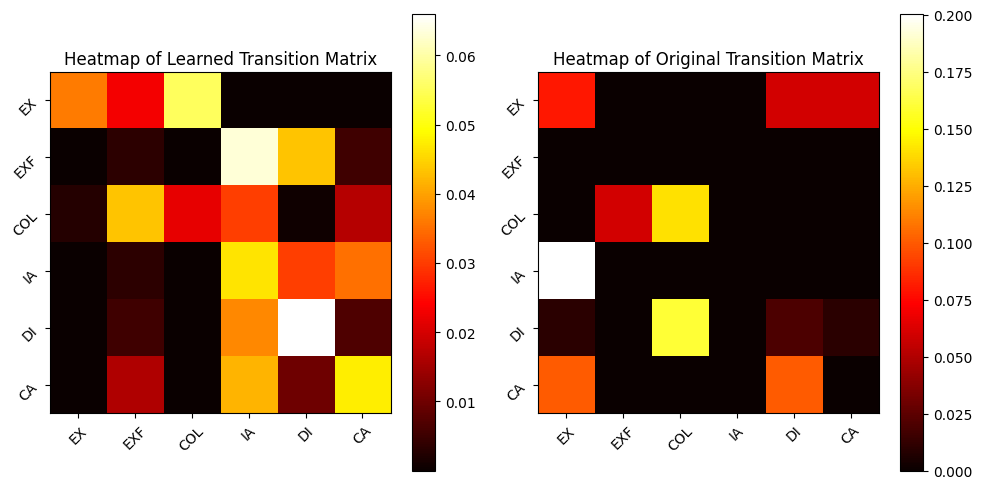

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
L = 6
og_states = ordered_apt.states[2:(2+L)]
# Plot the first heatmap
cax1 = axes[0].imshow(new_params[0][2:(2+L),2:(2+L)].cpu(), cmap='hot', interpolation='nearest')
# cax1 = axes[0].imshow(new_params[0].cpu(), cmap='hot', interpolation='nearest')
axes[0].set_xticks(np.arange(len(og_states)))
axes[0].set_xticklabels(og_states, rotation=45)
axes[0].set_yticks(np.arange(len(og_states)))
axes[0].set_yticklabels(og_states, rotation=45)

axes[0].set_title('Heatmap of Learned Transition Matrix')
fig.colorbar(cax1, ax=axes[0])

# Plot the second heatmap
cax2 = axes[1].imshow(true_hmm_params[0][2:(2+L),2:(2+L)].cpu(), cmap='hot', interpolation='nearest')
# cax2 = axes[1].imshow(hmm_params[0].cpu(), cmap='hot', interpolation='nearest')
axes[1].set_xticks(np.arange(len(og_states)))
axes[1].set_xticklabels(og_states, rotation=45)
axes[1].set_yticks(np.arange(len(og_states)))
axes[1].set_yticklabels(og_states, rotation=45)


axes[1].set_title('Heatmap of Original Transition Matrix')
fig.colorbar(cax2, ax=axes[1])

# Show the plots
plt.tight_layout()
plt.show()


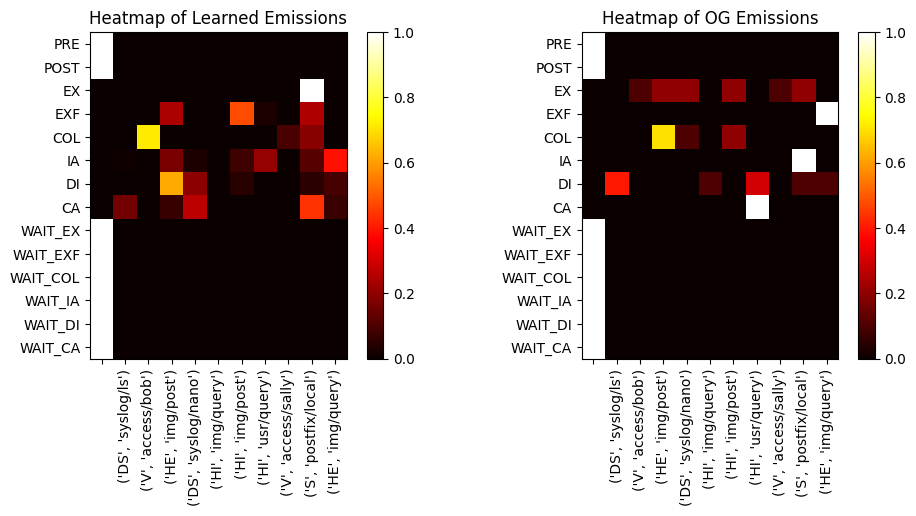

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first heatmap
cax1 = axes[0].imshow(new_params[1].cpu(), cmap='hot', interpolation='nearest')
axes[0].set_title('Heatmap of Learned Emissions')
axes[0].set_xticks(np.arange(len(list(ordered_apt.emits))))
axes[0].set_xticklabels(list(ordered_apt.emits), rotation=90)
axes[0].set_yticks(np.arange(len(list(ordered_apt.states))))
axes[0].set_yticklabels(list(ordered_apt.states))

fig.colorbar(cax1, ax=axes[0])

# Plot the second heatmap
cax2 = axes[1].imshow(true_hmm_params[1].cpu(), cmap='hot', interpolation='nearest')
axes[1].set_title('Heatmap of OG Emissions')
axes[1].set_xticks(np.arange(len(list(ordered_apt.emits))))
axes[1].set_xticklabels(list(ordered_apt.emits), rotation=90)
axes[1].set_yticks(np.arange(len(list(ordered_apt.states))))
axes[1].set_yticklabels(list(ordered_apt.states))

fig.colorbar(cax2, ax=axes[1])

# Show the plots
plt.tight_layout()
plt.show()


In [58]:
true_hmm_params[1].sum(dim=1)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

In [29]:
cst_names = ['dummy_constraint']
dummy_cst_list =  []
for name in cst_names:
    module = importlib.import_module(name)
    
    curr_cst =  Munch(name = module.name, \
                      aux_size = module.aug_size, \
                      update_fun = module.update_fun, \
                      init_fun = module.init_fun, \
                      forbidden_emissions = module.forbidden_emissions, \
                      forbidden_transitions = module.forbidden_transitions, \
                      knowledge_state = module.knowledge_state, \
                      cst_fun = module.cst_fun)
    if hasattr(module, 'dependency'):
        curr_cst.dependency = module.dependency
    dummy_cst_list.append(curr_cst)

# cst_list = cst_list
dummy_sat = len(dummy_cst_list) * (True,)


In [30]:
unc_new_apt, unc_new_params, unc_time_list = em.apt_EM_v2(apt_hmm, dummy_cst_list, seq_list,  device ='cuda:0', conv = 1e-4, max_step = 50, \
                                        dtype = torch.float32, rand_init = True, mix_param = .81, timer = True, fix_mu = None)

Step:0, neg log prob: 5020.578302383423, log_prob_change %: 0.013462376745479579
Step:1, neg log prob: 5004.601020812988, log_prob_change %: 0.003182358805727552
Step:2, neg log prob: 4992.432125329971, log_prob_change %: 0.002431541581918183
Step:3, neg log prob: 4978.73150241375, log_prob_change %: 0.002744278254021548
Step:4, neg log prob: 4963.247387647629, log_prob_change %: 0.003110052180683779
Step:5, neg log prob: 4949.407788038254, log_prob_change %: 0.002788416238090117
Step:6, neg log prob: 4936.275759220123, log_prob_change %: 0.0026532525466719525
Step:7, neg log prob: 4925.021585226059, log_prob_change %: 0.00227989167198438
Step:8, neg log prob: 4910.107374668121, log_prob_change %: 0.003028252830947351
Step:9, neg log prob: 4866.8812074661255, log_prob_change %: 0.008803507521038182
Step:10, neg log prob: 4789.229450702667, log_prob_change %: 0.015955137068958083
Step:11, neg log prob: 4684.207808256149, log_prob_change %: 0.02192871390430236
Step:12, neg log prob: 4631

In [31]:
unc_new_params[3]

0.8837883246245422

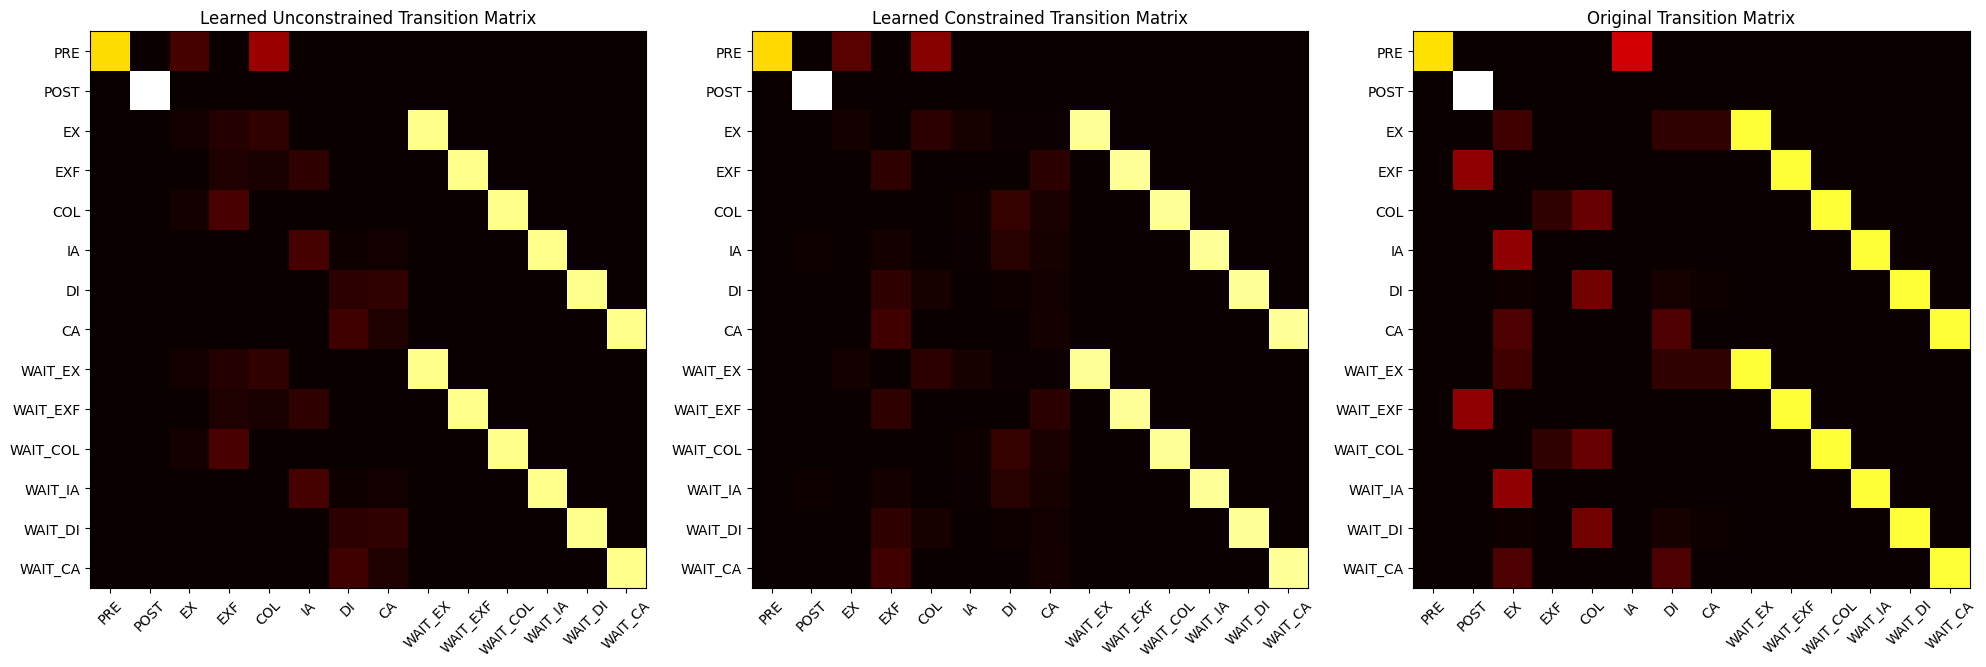

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Plot the first heatmap
# cax1 = axes[0].imshow(new_params[0][:(2+L),:(2+L)].cpu(), cmap='hot', interpolation='nearest')
cax1 = axes[0].imshow(unc_new_params[0].cpu(), cmap='hot', interpolation='nearest')
axes[0].set_title('Learned Unconstrained Transition Matrix')
axes[0].set_xticks(np.arange(len(list(ordered_apt.states))))
axes[0].set_xticklabels(list(ordered_apt.states), rotation=45)
axes[0].set_yticks(np.arange(len(list(ordered_apt.states))))
axes[0].set_yticklabels(list(ordered_apt.states))

# fig.colorbar(cax1, ax=axes[0])

# Plot the second heatmap
# cax2 = axes[1].imshow(hmm_params[0][:(2+L),:(2+L)].cpu(), cmap='hot', interpolation='nearest')
cax2 = axes[1].imshow(new_params[0].cpu(), cmap='hot', interpolation='nearest')
axes[1].set_title('Learned Constrained Transition Matrix')
axes[1].set_xticks(np.arange(len(list(ordered_apt.states))))
axes[1].set_xticklabels(list(ordered_apt.states), rotation=45)
axes[1].set_yticks(np.arange(len(list(ordered_apt.states))))
axes[1].set_yticklabels(list(ordered_apt.states))

# fig.colorbar(cax2, ax=axes[1])

cax3 = axes[2].imshow(true_hmm_params[0].cpu(), cmap='hot', interpolation='nearest')
axes[2].set_title('Original Transition Matrix')
axes[2].set_xticks(np.arange(len(list(ordered_apt.states))))
axes[2].set_xticklabels(list(ordered_apt.states), rotation=45)
axes[2].set_yticks(np.arange(len(list(ordered_apt.states))))
axes[2].set_yticklabels(list(ordered_apt.states))

# fig.colorbar(cax3, ax=axes[2])

# Show the plots
plt.tight_layout()
plt.show()


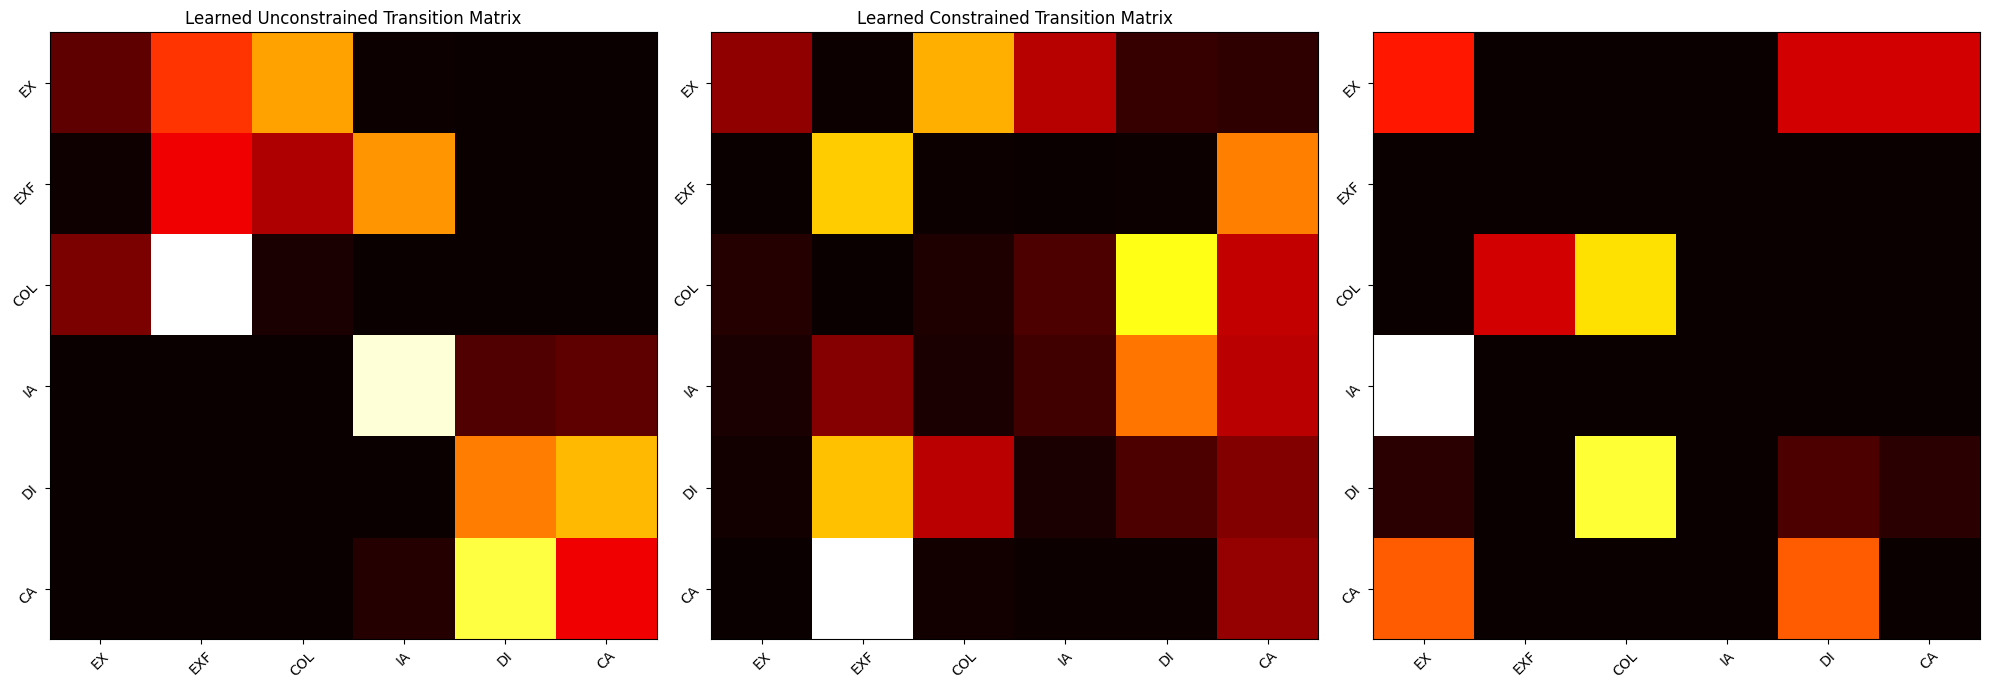

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
L = 6
og_states = ordered_apt.states[2:(2+L)]
# Plot the first heatmap
cax1 = axes[0].imshow(unc_new_params[0][2:(2+L),2:(2+L)].cpu(), cmap='hot', interpolation='nearest')
# cax1 = axes[0].imshow(new_params[0].cpu(), cmap='hot', interpolation='nearest')
axes[0].set_xticks(np.arange(len(og_states)))
axes[0].set_xticklabels(og_states, rotation=45)
axes[0].set_yticks(np.arange(len(og_states)))
axes[0].set_yticklabels(og_states, rotation=45)

axes[0].set_title('Learned Unconstrained Transition Matrix')
# fig.colorbar(cax1, ax=axes[0])

# Plot the second heatmap
cax2 = axes[1].imshow(new_params[0][2:(2+L),2:(2+L)].cpu(), cmap='hot', interpolation='nearest')
# cax2 = axes[1].imshow(hmm_params[0].cpu(), cmap='hot', interpolation='nearest')
axes[1].set_xticks(np.arange(len(og_states)))
axes[1].set_xticklabels(og_states, rotation=45)
axes[1].set_yticks(np.arange(len(og_states)))
axes[1].set_yticklabels(og_states, rotation=45)


axes[1].set_title('Learned Constrained Transition Matrix')
# fig.colorbar(cax2, ax=axes[1])

cax3 = axes[2].imshow(true_hmm_params[0][2:(2+L),2:(2+L)].cpu(), cmap='hot', interpolation='nearest')
# cax2 = axes[1].imshow(hmm_params[0].cpu(), cmap='hot', interpolation='nearest')
axes[2].set_xticks(np.arange(len(og_states)))
axes[2].set_xticklabels(og_states, rotation=45)
axes[2].set_yticks(np.arange(len(og_states)))
axes[2].set_yticklabels(og_states, rotation=45)

# Show the plots
plt.tight_layout()
plt.show()


In [368]:
new_hmm_params =  apt_Mstep(hmm_params,wait_list, ttl_gamma, ttl_xi)

In [372]:
new_hmm_params[3]

0.16352451601786186

In [376]:
A[2:(2+L),(2+L):].shape

torch.Size([6, 6])

In [377]:
    A_old , B_old, pi, _ = hmm_params
    wait_ix, delay_ix, L = wait_list

    A = torch.zeros(A_old.shape)
    B = B_old.clone()
    
    #update the mu parameter
    mu_const = torch.einsum('cjk,jk -> c',delay_ix, ttl_xi)
    mu = 1/(1+(mu_const[0].item()/mu_const[1].item())) #mu^* = 1/(1+C1/C2)
    
    #update the PRE > PRE,POST,OG transitions.
    A[0,:(2+L)] = ttl_xi[0,:(2+L)]/ttl_xi[0,:(2+L)].sum() #usual update eqn  for PRE

    #update STATE > POST, STATE transitions
    state_xi = torch.einsum('ij,jk -> ik', wait_ix, ttl_xi) #sum messages for OG and WAIT analogue. Transitions to POST, OG only
    ogA = state_xi[:,1:(2+L)]/state_xi[:,1:(2+L)].sum(dim = 1, keepdim=True)
    A[1,1] = 1. #POST absorbing
    A[2:(2+L), 1:(2+L)] = (1-mu)*ogA #fill in OG > POST, OG
    A[(2+L):, 1:(2+L)] = (1-mu)*ogA #copy WAIT > POST,OG

    #update transition to WAIT
    A[2:(2+L),(2+L):] = mu*torch.eye(L).to(device) #OG > WAIT
    A[(2+L):,(2+L):] = mu*torch.eye(L).to(device) #WAIT > WAIT

    #update emission matrix.
    #only update STATE emissions. PRE, POST, WAIT all fixed to None. OG cannot emit None
    B[2:(2+L),1:] = ttl_gamma[2:(2+L),1:]/ttl_gamma[2:(2+L),1:].sum(dim=1,keepdim=True)


In [378]:
ttl_xi[1,:]/ttl_xi[1,:].sum()

tensor([0.0729, 0.0303, 0.0622, 0.1178, 0.0663, 0.0714, 0.0786, 0.0831, 0.0598,
        0.0765, 0.0680, 0.0673, 0.0711, 0.0745], device='cuda:0')

In [379]:
A

tensor([[0.2466, 0.3577, 0.1389, 0.0388, 0.0656, 0.0610, 0.0258, 0.0656, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3419, 0.1503, 0.0547, 0.0834, 0.0817, 0.0625, 0.0619, 0.1635,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4058, 0.1326, 0.0492, 0.0750, 0.0663, 0.0528, 0.0548, 0.0000,
         0.1635, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3479, 0.1461, 0.0485, 0.0875, 0.0811, 0.0647, 0.0607, 0.0000,
         0.0000, 0.1635, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3412, 0.1438, 0.0563, 0.0864, 0.0819, 0.0624, 0.0644, 0.0000,
         0.0000, 0.0000, 0.1635, 0.0000, 0.0000],
        [0.0000, 0.3435, 0.1454, 0.0494, 0.0794, 0.0858, 0.0613, 0.0716, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1635, 0.0000],
        [0.0000, 0.3671, 0.1354, 0.0568, 0.0854, 0.0761, 0.0595, 0.0561, 0.0000,
  

In [256]:
hmm_params[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0391, 0.0308, 0.1082, 0.1010, 0.1219, 0.1022, 0.0119, 0.0311, 0.0715,
         0.0304, 0.0971, 0.1026, 0.1197, 0.0325],
        [0.0467, 0.1215, 0.0457, 0.0947, 0.0870, 0.0467, 0.0948, 0.1200, 0.0806,
         0.0460, 0.0600, 0.0862, 0.0532, 0.0169],
        [0.0021, 0.0090, 0.1217, 0.0363, 0.1431, 0.0548, 0.0171, 0.1279, 0.0304,
         0.0580, 0.1285, 0.0526, 0.1037, 0.1147],
        [0.0935, 0.0680, 0.0851, 0.0705, 0.0837, 0.1405, 0.1456, 0.0966, 0.0846,
         0.0017, 0.0181, 0.0151, 0.0599, 0.0369],
        [0.0568, 0.0394, 0.0833, 0.0684, 0.1344, 0.0784, 0.0897, 0.0140, 0.0127,
         0.0448, 0.1298, 0.0826, 0.0940, 0.0718],
        [0.0794, 0.0894, 0.0265, 0.1284, 0.0596, 0.0119, 0.0553, 0.0311, 0.0283,
         0.0522, 0.0561, 0.1005, 0.1318, 0.1496],
        [0.0575, 0.0110, 0.0874, 0.1089, 0.0757, 0.0455, 0.0670, 0.0738, 0.0965,
  

In [233]:
A

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0508, 0.0837, 0.0696, 0.0496, 0.0492, 0.0733, 0.0617, 0.0778, 0.0843,
         0.0807, 0.0792, 0.0849, 0.0776, 0.0776],
        [0.0455, 0.0874, 0.0608, 0.0605, 0.0454, 0.0616, 0.0650, 0.0643, 0.0879,
         0.0847, 0.0850, 0.0883, 0.0819, 0.0816],
        [0.0470, 0.0866, 0.0611, 0.0604, 0.0513, 0.0621, 0.0631, 0.0630, 0.0872,
         0.0841, 0.0841, 0.0875, 0.0812, 0.0812],
        [0.0420, 0.0869, 0.0599, 0.0592, 0.0523, 0.0602, 0.0656, 0.0668, 0.0876,
         0.0842, 0.0845, 0.0879, 0.0814, 0.0813],
        [0.0437, 0.0856, 0.0621, 0.0602, 0.0527, 0.0625, 0.0653, 0.0687, 0.0863,
         0.0828, 0.0833, 0.0866, 0.0803, 0.0799],
        [0.0429, 0.0851, 0.0637, 0.0603, 0.0527, 0.0639, 0.0648, 0.0696, 0.0857,
         0.0826, 0.0829, 0.0860, 0.0798, 0.0799],
        [0.0434, 0.0860, 0.0618, 0.0606, 0.0520, 0.0616, 0.0646, 0.0682, 0.0866,
  

In [203]:
new_hmm_params =  apt_Mstep(hmm_params,wait_list, ttl_gamma, ttl_xi)

In [204]:
new_hmm_params[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1199, 0.0611, 0.0627, 0.0474, 0.0474, 0.0786, 0.0907, 0.0662, 0.0660,
         0.0694, 0.0671, 0.0749, 0.0759, 0.0728],
        [0.1454, 0.0697, 0.0584, 0.0588, 0.0357, 0.0590, 0.0591, 0.0415, 0.0734,
         0.0760, 0.0748, 0.0831, 0.0840, 0.0811],
        [0.1616, 0.0675, 0.0574, 0.0579, 0.0391, 0.0603, 0.0563, 0.0423, 0.0701,
         0.0729, 0.0727, 0.0820, 0.0825, 0.0776],
        [0.1685, 0.0666, 0.0505, 0.0477, 0.0393, 0.0532, 0.0584, 0.0446, 0.0717,
         0.0757, 0.0732, 0.0843, 0.0851, 0.0812],
        [0.1729, 0.0664, 0.0543, 0.0529, 0.0375, 0.0571, 0.0554, 0.0432, 0.0698,
         0.0734, 0.0723, 0.0830, 0.0833, 0.0785],
        [0.1709, 0.0667, 0.0560, 0.0485, 0.0385, 0.0569, 0.0574, 0.0425, 0.0703,
         0.0738, 0.0728, 0.0833, 0.0836, 0.0788],
        [0.1735, 0.0686, 0.0502, 0.0452, 0.0382, 0.0531, 0.0555, 0.0431, 0.0719,
  

In [205]:
hmm_params[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1199, 0.0611, 0.0627, 0.0474, 0.0474, 0.0786, 0.0907, 0.0662, 0.0660,
         0.0694, 0.0671, 0.0749, 0.0759, 0.0728],
        [0.1454, 0.0697, 0.0584, 0.0588, 0.0357, 0.0590, 0.0591, 0.0415, 0.0734,
         0.0760, 0.0748, 0.0831, 0.0840, 0.0811],
        [0.1616, 0.0675, 0.0574, 0.0579, 0.0391, 0.0603, 0.0563, 0.0423, 0.0701,
         0.0729, 0.0727, 0.0820, 0.0825, 0.0776],
        [0.1685, 0.0666, 0.0505, 0.0477, 0.0393, 0.0532, 0.0584, 0.0446, 0.0717,
         0.0757, 0.0732, 0.0843, 0.0851, 0.0812],
        [0.1729, 0.0664, 0.0543, 0.0529, 0.0375, 0.0571, 0.0554, 0.0432, 0.0698,
         0.0734, 0.0723, 0.0830, 0.0833, 0.0785],
        [0.1709, 0.0667, 0.0560, 0.0485, 0.0385, 0.0569, 0.0574, 0.0425, 0.0703,
         0.0738, 0.0728, 0.0833, 0.0836, 0.0788],
        [0.1735, 0.0686, 0.0502, 0.0452, 0.0382, 0.0531, 0.0555, 0.0431, 0.0719,
  